In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
from tqdm import tqdm
import pandas as pd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import collections
from utils import progress_bar
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def NMAE(output,target):
     """ Returns the Normalized Mean Absolute Error
     """
    output=output.float()
    target=target.float()
    l1_norm=torch.norm((output-target),1)
    target_min=torch.min(target)
    target_max=torch.max(target)
    nmae=l1_norm/(target_max-target_min)
    return nmae.item()

In [4]:
def RE(output,target):
    """ Returns the Relative Error %
    """
    output=output.float()
    target=target.float()
    re=torch.norm((output-target))/(torch.norm(target))
    return re.item()*100

# Synthetic Data

In [5]:
X=np.random.randn(250,250)

In [6]:
n = 35000
i = np.random.randint(250, size=n) # Generate random row indexes
j = np.random.randint(250, size=n) # Generate random column indexes
X_values = X[i, j] # Extract those values from the matrix
n_user,n_movies=250,250
usr_max,mov_max=250,250

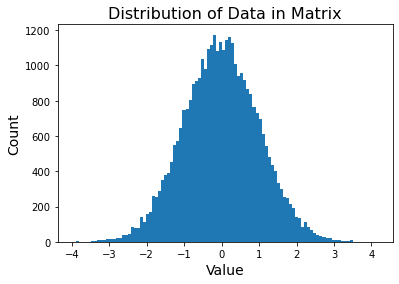

In [5]:
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

In [7]:
class Data(Dataset):
    def __init__(self,i,j,X,embed_size):
        
        self.user=i
        self.movie=j
        self.X=X
        self.embed_size=embed_size
        self.labels=(self.X)[self.user,self.movie]
        
    def __len__(self):
        
        return 1 
    
    def __getitem__(self,idx):
        
        starting_idx=idx*self.X.shape[0]
        user_idx=torch.FloatTensor(self.user)[starting_idx:starting_idx+X.shape[0]]
        movie_idx=torch.FloatTensor(self.movie)[starting_idx:starting_idx+X.shape[0]]
        y_true=torch.FloatTensor(self.labels)
        
        return (user_idx,movie_idx,y_true)

In [8]:
class LMF(nn.Module):
    
    def __init__(self,usr_size,mov_size,embed_size):
        
        super(LMF,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        
    def forward(self,in_dict):
        
        x1=in_dict['x1']
        x2=in_dict['x2']
        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)
        
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        
        x1=torch.squeeze(x1)
        x2=torch.squeeze(x2)
        
        x_out=x1.matmul(torch.transpose(x2,0,1))
        
        return x_out

class DMF(nn.Module):
    
    def __init__(self,usr_size,mov_size,n_user,n_movies,embed_size):
        
        super(DMF,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.n_u=n_user
        self.n_m=n_movies
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        self.fc1=nn.Linear((self.n_u)*self.e_s+(self.n_m)*self.e_s,512)
        self.fc2=nn.Linear(512,32)
        self.fc3=nn.Linear(32,(self.n_u)*(self.n_m))
        
    def forward(self,in_dict):  
        
        x1=in_dict['x1']
        x2=in_dict['x2']

        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)
        
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        
        shape1=x1.size()
        shape2=x2.size()
        x1=torch.squeeze(x1).view(shape1[1]*shape1[2])
        x2=torch.squeeze(x2).view(shape2[1]*shape2[2])
        x3=torch.cat([x1,x2],axis=-1)
        
        x4=self.fc1(x3)
        x4=nn.ReLU()(x4)
        x5=self.fc2(x4)
        x5=nn.ReLU()(x5)
        x_out=self.fc3(x5)
        
        return x_out

In [9]:
dataset=Data(i,j,X,25)
train_dl=DataLoader(dataset,)
valid_dl=DataLoader(dataset,)
dmf=DMF(usr_max,mov_max,n_user,n_movies,25)
lmf=LMF(usr_max,mov_max,25)
opt=torch.optim.SGD(list(lmf.parameters()),lr=1e-3)

In [12]:
def train1(model,train_dl,valid_dl,opt,num_epochs,i,j):
    
    """ Used to train a LMF or DMF model.
    Args:
        model: The class object of LMF or DMF 
        train_dl: DataLoader object containing the training data
        valid_dl: DataLoader object containing the validation data
        opt: Optimizer object 
        num_epochs: Number of epochs 
        (i,j): The index of non-missing entries in the given matrix
    """
    
    model=model.cuda()
    MSELoss=nn.MSELoss()
    v_losses=[]
    t_losses=[]
    in_dict=collections.defaultdict(lambda:[])
    
    for k in range(num_epochs):
        
        t_loss=0.0
        batch_idx=0
        
        for (user,movie,true) in train_dl:
            
            model.train()
            in_dict['x1']=user.cuda()
            in_dict['x2']=movie.cuda()
            user=user.cuda()
            movie=movie.cuda()
            true=torch.squeeze(true).cuda()
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            t_loss+=loss.item()
            loss.backward()
            opt.step()
            progress_bar(batch_idx, len(train_dl), 'Loss: %.5f '
                     % (t_loss/(batch_idx+1)))
            batch_idx+=1
            
        t_losses.append(t_loss/len(i))
        v_loss=0.0
        nmae=0.0
        re=0.0
        
        for (user,movie,true) in valid_dl:   
            
            model.eval()
            user=user.cuda()
            movie=movie.cuda()
            true=torch.squeeze(true).cuda()
            in_dict['x1']=user
            in_dict['x2']=movie
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            nmae+=NMAE(y_pred,true)
            re+=RE(y_pred,true)
            v_loss+=loss.item()
            
        v_losses.append(v_loss/len(i))
        print(f'Valid Loss in the {k}th epoch is {v_loss/n_movies}, NMAE is {nmae/n_movies} and RE is {re/n_movies}')
        
    plt.plot(list(range(num_epochs)),t_losses,label='Train Loss')
    plt.plot(list(range(num_epochs)),v_losses,label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

 [>................................................................]  Step: 2m5s | Tot: 4ms | Loss: 26.0363 1/1 
Valid Loss in the 0th epoch is 0.10405210876464843, NMAE is 74.27971875 and RE is 2.0359432220458986
 [>................................................................]  Step: 12ms | Tot: 3ms | Loss: 26.0130 1/1 
Valid Loss in the 1th epoch is 0.10395066833496094, NMAE is 74.243828125 and RE is 2.034950828552246
 [>................................................................]  Step: 9ms | Tot: 0ms | Loss: 25.9876 1/1 
Valid Loss in the 2th epoch is 0.10384091949462891, NMAE is 74.2049765625 and RE is 2.0338762283325194
 [>................................................................]  Step: 13ms | Tot: 4ms | Loss: 25.9602 1/1 
Valid Loss in the 3th epoch is 0.10372288513183593, NMAE is 74.1631640625 and RE is 2.0327199935913085
 [>................................................................]  Step: 12ms | Tot: 1ms | Loss: 25.9307 1/1 
Valid Loss in the 4th epoch 

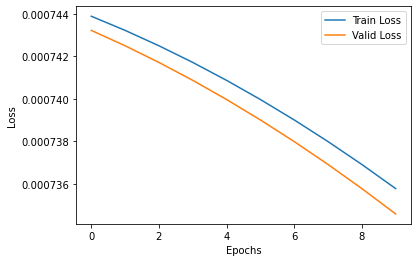

In [13]:
train1(lmf,train_dl,valid_dl,opt,10,i,j)

 [>................................................................]  Step: 4m18s | Tot: 5ms | Loss: 26.11 1/1 
Valid Loss in the 0th epoch is 26.116731643676758, NMAE is 0.47812762276785714 and RE is 0.014713035311017718
 [>................................................................]  Step: 24ms | Tot: 6ms | Loss: 26.11 1/1 
Valid Loss in the 1th epoch is 26.112268447875977, NMAE is 0.47808839285714283 and RE is 0.014711781910487583
 [>................................................................]  Step: 19ms | Tot: 3ms | Loss: 26.11 1/1 
Valid Loss in the 2th epoch is 26.10557746887207, NMAE is 0.4780287388392857 and RE is 0.014709889548165458
 [>................................................................]  Step: 14ms | Tot: 1ms | Loss: 26.10 1/1 
Valid Loss in the 3th epoch is 26.096660614013672, NMAE is 0.47794787946428574 and RE is 0.014707390921456473
 [>................................................................]  Step: 20ms | Tot: 5ms | Loss: 26.09 1/1 
Valid 

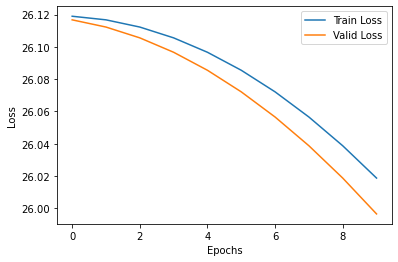

In [60]:
train(dmf,train_dl,valid_dl,opt,10,i,j)

# MovieLens100K

In [54]:
data = pd.read_csv('./ml-100k/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


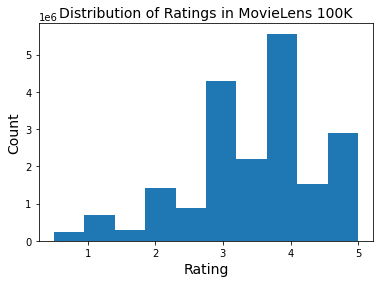

In [43]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 100K", fontsize=14)
plt.show()

In [55]:
n = 100000
n_user, n_movies =943,1682
usr_max,mov_max=data['userId'].values[:n].max()-1,data['movieId'].values[:n].max()-1
i = np.random.randint(n_user, size=n) # Generate random row indexes
j = np.random.randint(n_movies, size=n)

In [56]:
class MovieLens(Dataset):
    
    def __init__(self,data,n,n_users,n_movies):
        
        self.data=data
        self.n=n
        self.n_movies=n_movies
        self.n_users=n_users
        
    def __len__(self):
        
            return 1 
        
    def __getitem__(self,idx):
        
        users = self.data['userId'].values[:self.n] - 1 # Offset by 1 so that the IDs start at 0
        movies = self.data['movieId'].values[:self.n] - 1 # Offset by 1 so that the IDs start at 0
        ratings = self.data['rating'].values[:n]
        user_idx=torch.FloatTensor(users)[idx*self.n_users:idx*self.n_users+self.n_users]
        movie_idx=torch.FloatTensor(movies)[idx*self.n_movies:idx*self.n_movies+n_movies]
        y_true=torch.FloatTensor(ratings)

        return (user_idx,movie_idx,y_true)


In [57]:
class LMF_M(nn.Module):
    
    def __init__(self,usr_size,mov_size,embed_size):
        
        super(LMF_M,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        
    def forward(self,in_dict):
        
        x1=in_dict['x1']
        x2=in_dict['x2']
        
        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)   
        
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        
        x1=torch.squeeze(x1)
        x2=torch.squeeze(x2)
        x_out=x1.matmul(torch.transpose(x2,0,1))
        
        return x_out

class DMF_M(nn.Module):
    
    def __init__(self,usr_size,mov_size,n_user,n_movies,embed_size):
        
        super(DMF_M,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.n_u=n_user
        self.n_m=n_movies
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        self.fc1=nn.Linear((self.n_u)*self.e_s+(self.n_m)*self.e_s,512)
        self.fc2=nn.Linear(512,32)
        self.fc3=nn.Linear(32,(self.n_u)*(self.n_m))
        
    def forward(self,in_dict):
        
        x1=in_dict['x1']
        x2=in_dict['x2']

        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)
        
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        
        shape1=x1.size()
        x1=torch.squeeze(x1).view(shape1[1]*shape1[2])
        x3=torch.cat([x1,x2],axis=-1)
        
        x4=self.fc1(x3)
        x4=nn.ReLU()(x4)
        x5=self.fc2(x4)
        x5=nn.ReLU()(x5)
        x_out=self.fc3(x5)
        
        return x_out

In [49]:
dataset=MovieLens(data,n,n_user,n_movies)
train_dl=DataLoader(dataset)
valid_dl=DataLoader(dataset)
dmf=DMF_M(usr_max,mov_max,n_user,n_movies,25)
lmf=LMF_M(usr_max,mov_max,25)
opt=torch.optim.SGD(list(lmf.parameters()),lr=1e-3)

In [52]:
def train2(model,train_dl,valid_dl,opt,num_epochs,i,j):
    
    """ Used to train a LMF or DMF model.
    Args:
        model: The class object of LMF or DMF 
        train_dl: DataLoader object containing the training data
        valid_dl: DataLoader object containing the validation data
        opt: Optimizer object 
        num_epochs: Number of epochs 
        (i,j): The index of non-missing entries in the given matrix
    """
    
    model=model.cuda()
    MSELoss=nn.MSELoss()
    v_losses=[]
    t_losses=[]
    in_dict=collections.defaultdict(lambda:[])
    
    for k in range(num_epochs):
        
        t_loss=0.0
        batch_idx=0
        
        for (user,movie,true) in train_dl:
            
            model.train()
            in_dict['x1']=user.cuda()
            in_dict['x2']=movie.cuda()
            user=user.cuda()
            movie=movie.cuda()
            true=true.cuda()
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            t_loss+=loss.item()
            loss.backward()
            opt.step()
            progress_bar(batch_idx, len(train_dl), 'Loss: %.5f '
                     % (t_loss/(batch_idx+1)))
            batch_idx+=1
            
        t_losses.append(t_loss/len(train_dl))
        v_loss=0.0
        nmae=0.0
        re=0.0
        
        for (user,movie,true) in valid_dl: 
            
            model.eval()
            user=user.cuda()
            movie=movie.cuda()
            true=true.cuda()
            in_dict['x1']=user
            in_dict['x2']=movie
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            v_loss+=loss.item()
            nmae+=NMAE(y_pred,true)
            re+=RE(y_pred,true)
            
        v_losses.append(v_loss/len(valid_dl))
        print(f'Valid Loss in the {k}th epoch is {v_loss/n_movies}, NMAE is {nmae/n_movies} and RE is {re/n_movies}')
        
    plt.plot(list(range(num_epochs)),t_losses,label='Train Loss')
    plt.plot(list(range(num_epochs)),v_losses,label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show

 [>................................................................]  Step: 20s794ms | Tot: 0ms | Loss: 41.82 1/1 
Valid Loss in the 0th epoch is 41.7988166809082, NMAE is 1.1600096875 and RE is 0.0017639825344085694
 [>................................................................]  Step: 60ms | Tot: 1ms | Loss: 41.79 1/1 
Valid Loss in the 1th epoch is 41.75410842895508, NMAE is 1.1594315625 and RE is 0.0017630341053009033
 [>................................................................]  Step: 70ms | Tot: 6ms | Loss: 41.75 1/1 
Valid Loss in the 2th epoch is 41.68716049194336, NMAE is 1.158545625 and RE is 0.0017616218328475952
 [>................................................................]  Step: 66ms | Tot: 0ms | Loss: 41.68 1/1 
Valid Loss in the 3th epoch is 41.598121643066406, NMAE is 1.1573575 and RE is 0.0017597389221191407
 [>................................................................]  Step: 78ms | Tot: 0ms | Loss: 41.59 1/1 
Valid Loss in the 4th epoch is 41

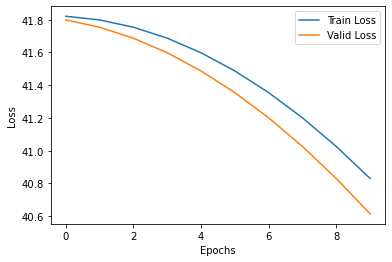

In [49]:
train2(lmf,train_dl,valid_dl,opt,10,i,j)

 [>................................................................]  Step: 18s263ms | Tot: 1ms | Loss: 13.44 1/1 
Valid Loss in the 0th epoch is 13.43975830078125, NMAE is 0.779272734375 and RE is 0.0010002459287643433
 [>................................................................]  Step: 498ms | Tot: 2ms | Loss: 13.44 1/1 
Valid Loss in the 1th epoch is 13.439595222473145, NMAE is 0.779273203125 and RE is 0.0010002422332763671
 [>................................................................]  Step: 651ms | Tot: 4ms | Loss: 13.44 1/1 
Valid Loss in the 2th epoch is 13.43937873840332, NMAE is 0.779279140625 and RE is 0.0010002334117889405
 [>................................................................]  Step: 481ms | Tot: 1ms | Loss: 13.43 1/1 
Valid Loss in the 3th epoch is 13.439180374145508, NMAE is 0.779288203125 and RE is 0.0010002268552780152
 [>................................................................]  Step: 480ms | Tot: 0ms | Loss: 13.43 1/1 
Valid Loss in t

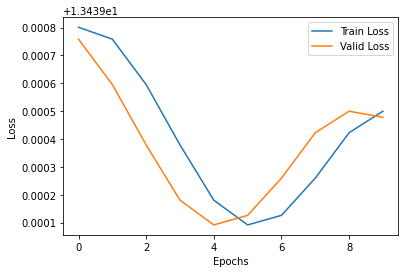

In [41]:
train2(dmf,train_dl,valid_dl,opt,10,i,j)

# Jester-Joker-1 dataset

In [14]:
joker=pd.read_csv('jester-data-1.csv',)

In [71]:
joker.head()

,a,a.1,a.2,a.3,a.4,a.5,a.6,a.7,a.8,a.9,...,a.91,a.92,a.93,a.94,a.95,a.96,a.97,a.98,a.99,a.100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [27]:
joker.shape

(24983, 101)

In [21]:
n=749490
n_user=joker.shape[0]
n_movies=joker.shape[1]-1
usr_max=joker['a'].max()+1
mov_max=joker.shape[1]
i = np.random.randint(joker.shape[0]-1, size=n) # Generate random row indexes
j = np.random.randint(joker.shape[1]-1, size=n) # Generate random column indexes

In [20]:
class JesterJoker(Dataset):
    
    def __init__(self,joker,n,i,j):
        
        self.joker=joker
        self.n=n
        self.i=i
        self.j=j
        
    def __len__(self):

        return 1  
        
    def __getitem__(self,idx):
        
        user=self.joker['a']
        movie=list(range(0,len(self.joker.columns)-1))
        joker=self.joker.values[i,j]
        user_idx=torch.FloatTensor(user)
        movie_idx=torch.FloatTensor(movie)
        y_true=torch.FloatTensor(joker)
        
        return (user_idx,movie_idx,y_true)


In [17]:
class LMF_J(nn.Module):
    
    def __init__(self,usr_size,mov_size,embed_size):
        
        super(LMF_J,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        
    def forward(self,in_dict):
        
        x1=in_dict['x1']
        x2=in_dict['x2']
        
        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)
    
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        x1=torch.squeeze(x1)
        x2=torch.squeeze(x2)
        x_out=x1.matmul(torch.transpose(x2,0,1))
        
        return x_out

class DMF_J(nn.Module):
    
    def __init__(self,usr_size,mov_size,n_user,n_movies,embed_size):
        
        super(DMF_J,self).__init__()
        self.u_s=usr_size
        self.m_s=mov_size
        self.e_s=embed_size
        self.n_u=n_user
        self.n_m=n_movies
        self.embed1=nn.Embedding(num_embeddings=self.u_s,embedding_dim=self.e_s)
        self.embed2=nn.Embedding(num_embeddings=self.m_s,embedding_dim=self.e_s)
        self.fc1=nn.Linear((self.n_u)*self.e_s+(self.n_m)*self.e_s,50)
        self.fc2=nn.Linear(50,(self.n_u)*(self.n_m))
        
    def forward(self,in_dict):
        
        x1=in_dict['x1']
        x2=in_dict['x2']
        
        x1=Variable(x1,requires_grad=True)
        x1=torch.tensor(x1).to(torch.int64)
        x1=self.embed1(x1)
        
        x2=Variable(x2,requires_grad=True)
        x2=torch.tensor(x2).to(torch.int64)
        x2=self.embed2(x2)
        
        shape1=x1.size()
        shape2=x2.size()
        x1=torch.squeeze(x1).view(shape1[1]*shape1[2])
        x2=torch.squeeze(x2).view(shape2[1]*shape2[2])
        x3=torch.cat([x1,x2],axis=-1)
        
        x4=self.fc1(x3)   
        x4=nn.ReLU()(x4)
        x_out=self.fc2(x4)        
        
        return x_out

In [5]:
def train3(model,train_dl,valid_dl,opt,num_epochs,i,j):
    
       """ Used to train a LMF or DMF model.
    Args:
        model: The class object of LMF or DMF 
        train_dl: DataLoader object containing the training data
        valid_dl: DataLoader object containing the validation data
        opt: Optimizer object 
        num_epochs: Number of epochs 
        (i,j): The index of non-missing entries in the given matrix
    """
        
    model=model.cuda()
    MSELoss=nn.MSELoss()
    v_losses=[]
    t_losses=[]
    in_dict=collections.defaultdict(lambda:[])
    
    for k in range(num_epochs):
        
        t_loss=0.0
        batch_idx=0
        
        for (user,movie,true) in train_dl:
            
            model.train()
            in_dict['x1']=user.cuda()
            in_dict['x2']=movie.cuda()
            user=user.cuda()
            movie=movie.cuda()
            true=true.cuda()
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            t_loss+=loss.item()
            loss.backward()
            opt.step()
            progress_bar(batch_idx, len(train_dl), 'Loss: %.5f '
                     % (t_loss/(batch_idx+1)))
            batch_idx+=1
            
        t_losses.append(t_loss/len(i))
        v_loss=0.0
        nmae=0.0
        re=0.0
        
        for (user,movie,true) in valid_dl:   
            
            model.eval()
            user=user.cuda()
            movie=movie.cuda()
            true=true.cuda()
            in_dict['x1']=user
            in_dict['x2']=movie
            y_pred=model(in_dict)
            y_pred=y_pred.view(n_user,n_movies)
            y_pred=y_pred[i,j]
            loss=MSELoss(y_pred,true)
            v_loss+=loss.item()
            nmae+=NMAE(y_pred,true)
            re+=RE(y_pred,true)
            
        v_losses.append(v_loss/len(i))
        print(f'Valid Loss in the {k}th epoch is {v_loss/len(i)}, NMAE is {nmae/len(i)} and RE is {re/len(i)}')
        
    plt.plot(list(range(num_epochs)),t_losses,label='Train Loss')
    plt.plot(list(range(num_epochs)),v_losses,label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show

In [22]:
dataset=JesterJoker(joker,n,i,j)
train_dl=DataLoader(dataset)
valid_dl=DataLoader(dataset)
dmf=DMF_J(usr_max,mov_max,n_user,n_movies,5)
lmf=LMF_J(usr_max,mov_max,25)
opt=torch.optim.SGD(list(lmf.parameters()),lr=1e-3)

 [>................................................................]  Step: 9s775ms | Tot: 4ms | Loss: 2739.24 1/1 
Valid Loss in the 0th epoch is 0.0010963778611643418, NMAE is 0.28878935175919623 and RE is 4.0199640862903475e-05
 [>................................................................]  Step: 332ms | Tot: 0ms | Loss: 2739.08 1/1 
Valid Loss in the 1th epoch is 0.0010962507239297723, NMAE is 0.28876023195773126 and RE is 4.0197312314158294e-05
 [>................................................................]  Step: 335ms | Tot: 0ms | Loss: 2738.76 1/1 
Valid Loss in the 2th epoch is 0.0010960602623846715, NMAE is 0.28871662730656844 and RE is 4.019381949104053e-05
 [>................................................................]  Step: 338ms | Tot: 0ms | Loss: 2738.28 1/1 
Valid Loss in the 3th epoch is 0.0010958065742517412, NMAE is 0.288658762958812 and RE is 4.018916716516645e-05
 [>................................................................]  Step: 399ms | To

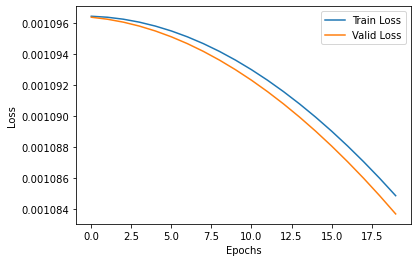

In [35]:
train3(lmf,train_dl,valid_dl,opt,20,i,j)

 [>................................................................]  Step: 18m37s | Tot: 0ms | Loss: 2721.63 1/1 
Valid Loss in the 0th epoch is 0.0036313114141574604, NMAE is 0.2789409506797956 and RE is 0.00013344413429444197
 [>................................................................]  Step: 1s997ms | Tot: 0ms | Loss: 2721.63 1/1 
Valid Loss in the 1th epoch is 0.0036313114141574604, NMAE is 0.2789409506797956 and RE is 0.00013344413429444197
 [>................................................................]  Step: 3s643ms | Tot: 1ms | Loss: 2721.63 1/1 
Valid Loss in the 2th epoch is 0.0036313114141574604, NMAE is 0.2789409506797956 and RE is 0.00013344413429444197
 [>................................................................]  Step: 683ms | Tot: 2ms | Loss: 2721.63 1/1 
Valid Loss in the 3th epoch is 0.0036313114141574604, NMAE is 0.2789409506797956 and RE is 0.00013344413429444197
 [>................................................................]  Step: 679ms |

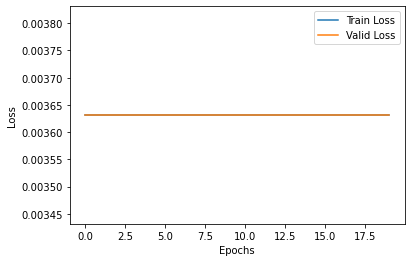

In [24]:
train3(dmf,train_dl,valid_dl,opt,20,i,j)